# Humpback Whale Matching CNN  

Use the cleaned and augmented data to develop a CNN model that will identify and match pictures of whale fines to individual whales.  

First, we will attempt to fit a CNN model on a small subset of the training data to ensure that the model will actually fit on the data.

In [1]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#navigate to where the data is located
%cd /content/drive/MyDrive/cisc867/project/

/content/drive/MyDrive/cisc867/project


In [3]:
#import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("data/"))

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')



['sample_submission.csv', 'train.csv', '.ipynb_checkpoints', 'test', 'train', 'train_processed', 'validation.csv', 'test.csv', 'test_processed', 'validation_processed']


In [4]:
#read in the train data

train = pd.read_csv("./data/train.csv")
print(train.head())

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


In [5]:
# The info() method prints information about the DataFrame.
# The information contains the number of columns, column labels, column data types,
# memory usage, range index, and the number of cells in each column (non-null values).
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   25361 non-null  object
 1   Id      25361 non-null  object
dtypes: object(2)
memory usage: 396.4+ KB


In [6]:
# The describe() method is used for calculating some statistical data like percentile,
# mean and std of the numerical values of the Series or DataFrame.
# It analyzes both numeric and object series and also the DataFrame column sets of mixed data types.
train.describe()

,Image,Id
count,25361,25361
unique,25361,5005
top,0000e88ab.jpg,new_whale
freq,1,9664


In [7]:
#count the number of images per whale
df2 = train.groupby('Id').agg('count').rename({'Image': 'NumImages'}, axis=1)
df2.sort_values('NumImages', ascending=False, inplace=True)
df2


,NumImages
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
...,...
w_49ee8e0,1
w_49e0d44,1
w_49d1bcd,1


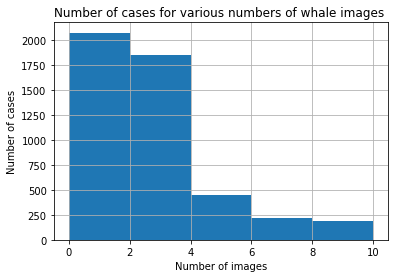

In [8]:
plt.figure(figsize=(6, 4))
df2.NumImages.hist(bins=list(range(0, 11, 2)))
plt.title('Number of cases for various numbers of whale images ')
plt.xlabel('Number of images')
plt.ylabel('Number of cases')
plt.show()

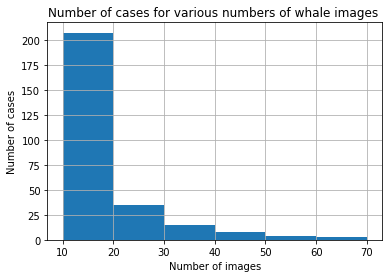

In [9]:
plt.figure(figsize=(6, 4))
df2.NumImages.hist(bins=list(range(10, 71, 10)))
plt.title('Number of cases for various numbers of whale images ')
plt.xlabel('Number of images')
plt.ylabel('Number of cases')
plt.show()

In [10]:
#we don't want new_whales as those are whales without an ID
df2.drop('new_whale', inplace=True)
df2

,NumImages
Id,
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
...,...
w_49ee8e0,1
w_49e0d44,1
w_49d1bcd,1


In [11]:
#restrict to only whales with more than 20 images each
NUM_IMAGES_THRESHOLD = 5

df3 = df2.query(f'NumImages > {NUM_IMAGES_THRESHOLD}')

print('shape:', df3.shape)
print('total number of images:', df3.NumImages.sum())
df3.head()



shape: (633, 1)
total number of images: 7398


,NumImages
Id,
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57


In [12]:
ids_to_leave = list(df3.index)

filtered_df = train.query(f'Id in {ids_to_leave}')
filtered_df

,Image,Id
0,0000e88ab.jpg,w_f48451c
6,000a6daec.jpg,w_dd88965
10,001cae55b.jpg,w_581ba42
21,00442c882.jpg,w_8cad422
26,004e8ad5b.jpg,w_3de579a
...,...,...
25347,ffcd5efdc.jpg,w_f765256
25354,ffe52d320.jpg,w_bc285a6
25356,ffef89eed.jpg,w_9c506f6
25357,fff7faf61.jpg,w_9cf0388


In [13]:
#split into training and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

x, y = filtered_df.Image, filtered_df.Id
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_indices, val_indices = list(splitter.split(x, y))[0]

print('shapes:', train_indices.shape, val_indices.shape)

train_df = filtered_df.iloc[train_indices]
val_df = filtered_df.iloc[val_indices]

train_df.Id.nunique() == val_df.Id.nunique()

shapes: (5548,) (1850,)


True

We want our output variable to be Id as we want to identify the whale based on the fin. To do this we need to separate the Id and the other variables.

In [14]:
# put labels into y_train variable
y_train = train_df["Id"]
y_val = val_df["Id"]
# Drop the 'Id' column
x_train = train_df.drop(labels = ["Id"], axis = 1)
x_val = val_df.drop(labels = ["Id"], axis = 1)
y_train.head()

2969     w_ec32fa6
16893    w_17b0d3a
21265    w_55b77ce
11505    w_fe881f2
12662    w_778e474
Name: Id, dtype: object

In [15]:
# Indicates sum of values in our data
# train.isnull().sum()


So, no row or column data is missing means we don't have to preprocess the data, but we do need to preprocess the images themselves which for us has already been done.

In [16]:
# importing the libraries for image preprocessing
from tensorflow.keras.utils import load_img, img_to_array 

In [17]:
# add the images as an array to the training data
def prepareImages(train, shape, path):
    
    x_train = np.zeros((shape, 100, 100, 3))
    count = 0
    
    for fig in train['Image']:
        
        #load images into images of size 100x100x3
        img = load_img("./data/"+path+"/"+fig, target_size=(100, 100, 3))
        x = img_to_array(img)

        x_train[count] = x
        if (count%1000 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return x_train

x_train = prepareImages(x_train, x_train.shape[0], "train_processed")
x_val = prepareImages(x_val, x_val.shape[0], "train_processed")

Processing image:  1 ,  1e78cdeb7.jpg
Processing image:  1001 ,  07b048c72.jpg
Processing image:  2001 ,  e9c44c8e6.jpg
Processing image:  3001 ,  5b0aeacb0.jpg
Processing image:  4001 ,  81787a873.jpg
Processing image:  5001 ,  fc1de6d65.jpg
Processing image:  1 ,  e001ea7da.jpg
Processing image:  1001 ,  2cd419554.jpg


In [18]:
print("xtrain shape: ",x_train.shape)
print("xval shape: ",x_val.shape)

xtrain shape:  (5548, 100, 100, 3)
xval shape:  (1850, 100, 100, 3)


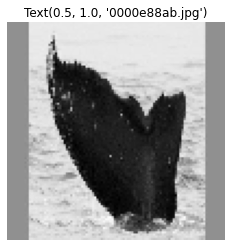

In [19]:
# Checking example input image
plt.imshow(x_train[0][:,:,0], cmap="gray")
plt.title(plt.title(train.iloc[0,0]))
plt.axis("off")
plt.show()

As we are performing classification, label encoding simplifies this process. 

1. Encode target labels with value between 0 and n_classes-1.

2. This transformer should be used to encode target values, i.e. y, and not the input X.

Note:- Label encoding converts the data in machine-readable form, but it assigns a unique number(starting from 0) to each class of data. This may lead to the generation of priority issues in the training of data sets. A label with a high value may be considered to have high priority than a label having a lower value.



In [20]:
#import the LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [21]:
#Fit label encoder and return encoded labels.
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)

# let's look at first 10 values
y_train[0:10]  

array([583,  64, 194, 631, 284, 428, 133, 116, 370, 211])

In [22]:
# finding shape of y_train data, since it is the same as before, we know that it is done correctly
print(y_train.shape)
print(y_val)

(5548,)
[147 178 308 ... 264 573 133]


In [23]:
# convert to one-hot-encoding
# we got 4251 classes from the function train.Id.describe()

from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 4251)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
y_val = to_categorical(y_val, num_classes = 4251)
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Implementation of CNN Model

We will use Keras to implement the CNN model now that the data is in the proper format. 

### Convolutional layer

1. This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

2. When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers or None, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last". You can use None when a dimension has variable size.

3. filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

4. kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.

5. strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.

6. padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.

7. kernel_initializer: Initializer for the kernel weights matrix (see keras.initializers). Defaults to 'glorot_uniform'.

#### Padding 

1. When padding == ”VALID”, the input image is not padded. When padding == "VALID", there can be a loss of information and (Input Size != Output Size)

2. When padding == “SAME”, the output size is the same as the input size(when stride=1). Normally, padding is set to "SAME" while training the model. Output size is mathematically convenient for further computation.

3. Size of each feature map = [N-f+2P /S] + 1



#### Maxpooling2D

1. Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

2. The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of: output_shape = math.floor((input_shape - pool_size) / strides) + 1 (when input_shape >= pool_size)

3. The resulting output shape when using the "same" padding option is: output_shape = math.floor((input_shape - 1) / strides) + 1

#### Dropout layer

1. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note: that the Dropout layer only applies when training is set to True such that no values are dropped during inference. When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.

#### Flatten layer

1. Flattens the input.

2. If inputs are shaped (batch,) without a feature axis, then flattening adds an extra channel dimension and output shape is (batch, 1).




In [25]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 33.5 MB/s 
     |████████████████████████████████| 1.6 MB 42.6 MB/s 


In [26]:
# develop the CNN
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # to create a cnn model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt

def model_builder(hp):

  model = Sequential()

  rate = hp.Choice('rate', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

  model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = hp.Choice('activation', ['tanh', 'relu']), input_shape = (100,100,3)))
  model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = hp.Choice('activation', ['tanh', 'relu'])))
  model.add(MaxPool2D(pool_size = (2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = hp.Choice('activation', ['tanh', 'relu'])))
  model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = hp.Choice('activation', ['tanh', 'relu'])))
  model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
  model.add(Dropout(rate))

  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = hp.Choice('activation', ['tanh', 'relu'])))
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = hp.Choice('activation', ['tanh', 'relu'])))
  model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
  model.add(BatchNormalization())

  # fully connected
  model.add(Flatten())
  model.add(Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"])))
  model.add(BatchNormalization())
  model.add(Dense(y_train.shape[1], activation = "softmax"))

  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  # Define the optimizer
  optimizer = Adam(lr = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
  #compile the model
  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

  return model

In [27]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='my_dir',
                     project_name='cnn_tuning')
# tuner = kt.RandomSearch(
#     hypermodel=model_builder,
#     objective="val_accuracy",
#     max_trials=3,
#     executions_per_trial=2,
#     overwrite=True,
#     directory="my_dir",
#     project_name="cnn_tuner",
    
# )
tuner.search_space_summary()

Search space summary
Default search space size: 4
rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'ordered': True}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [28]:
import tensorflow as tf
#Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#search for best values
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()
tuner.results_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        9

## Fit the Model

In [29]:
history = best_model.fit(x_train, y_train, epochs=50, verbose = 2, validation_data=(x_val, y_val), callbacks=[stop_early]) 

Epoch 1/50
174/174 - 118s - loss: 0.0111 - accuracy: 0.9993 - val_loss: 2.8779 - val_accuracy: 0.4503 - 118s/epoch - 678ms/step
Epoch 2/50
174/174 - 108s - loss: 0.0102 - accuracy: 0.9991 - val_loss: 2.8716 - val_accuracy: 0.4427 - 108s/epoch - 621ms/step
Epoch 3/50
174/174 - 105s - loss: 0.0111 - accuracy: 0.9993 - val_loss: 3.0113 - val_accuracy: 0.4308 - 105s/epoch - 604ms/step
Epoch 4/50
174/174 - 105s - loss: 0.0219 - accuracy: 0.9980 - val_loss: 3.0899 - val_accuracy: 0.4319 - 105s/epoch - 605ms/step
Epoch 5/50
174/174 - 105s - loss: 0.0126 - accuracy: 0.9993 - val_loss: 2.8849 - val_accuracy: 0.4449 - 105s/epoch - 606ms/step
Epoch 6/50
174/174 - 112s - loss: 0.0125 - accuracy: 0.9991 - val_loss: 2.9143 - val_accuracy: 0.4568 - 112s/epoch - 642ms/step
Epoch 7/50
174/174 - 107s - loss: 0.0083 - accuracy: 0.9991 - val_loss: 2.9379 - val_accuracy: 0.4449 - 107s/epoch - 617ms/step


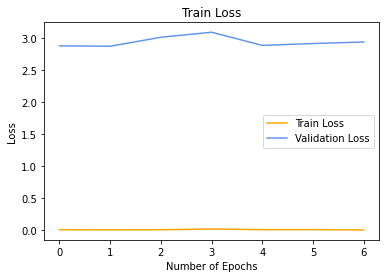

In [34]:
# Plot the loss curve for training
plt.plot(history.history['loss'], color='orange', label="Train Loss")
plt.plot(history.history['val_loss'], color = 'cornflowerblue', label = 'Validation Loss')
plt.title("Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

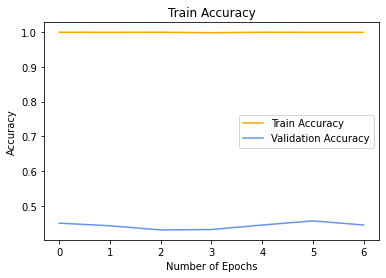

In [35]:
# Plot the accuracy curve for training
plt.plot(history.history['accuracy'], color='orange', label="Train Accuracy")
plt.plot(history.history['val_accuracy'], color = 'cornflowerblue', label = 'Validation Accuracy')
plt.title("Train Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [32]:
# finding the training accuracy 
print('Train accuracy of the model: ',history.history['accuracy'][-1])

# finding the training loss 
print('Train loss of the model: ',history.history['loss'][-1])


Train accuracy of the model:  0.9990987777709961
Train loss of the model:  0.008293796330690384


In [33]:
import pickle
filename = 'tuned_cnn_model2.sav'
pickle.dump(best_model, open(filename, 'wb'))